## 1

**Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?**

The goal of this project is to train a supervised machine learning algorithm for prediction.  To do this, we'll be using the Enron data set.  This data set contains financial information and email data from various employees in that former company.  Enron was an energy commodities and services corporation that went bankrupt in 2001 due to fraud.  The supervised model will attempt to classify whether or not an employee was a person of interest (ie whether or not they were complicit).

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import pickle

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

financial_features = ['salary', 'deferral_payments', 'total_payments',
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income',
'total_stock_value', 'expenses', 'exercised_stock_options', 'other',
'long_term_incentive', 'restricted_stock', 'director_fees']
# all units in USD
email_features = ['to_messages', 'from_poi_to_this_person', 'email_address',
'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
# email_address only non-numeric
poi_label = ['poi'] # boolean
# include all features to start
features_list = poi_label + financial_features + email_features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
### Task 2: Remove outliers

import pandas as pd
import numpy as np

df = pd.DataFrame.from_dict(data_dict, orient = 'index')
#print df.isnull().any()
# NaN values are actually strings
df = df.replace('NaN', np.nan) # works better than '0' for stats/plots
# general data set information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [4]:
# number of POIs
sum(df.poi == True)

18

There are 146 observations (people) in the data set and a total of 21 features.  Out of 146 people, 18 are persons of interest.  Some features have more missing values than others.  Below is the percentage of missing values in each feature.

In [5]:
100* df.isnull().sum() / df.shape[0]

salary                       34.931507
to_messages                  41.095890
deferral_payments            73.287671
total_payments               14.383562
exercised_stock_options      30.136986
bonus                        43.835616
restricted_stock             24.657534
shared_receipt_with_poi      41.095890
restricted_stock_deferred    87.671233
total_stock_value            13.698630
expenses                     34.931507
loan_advances                97.260274
from_messages                41.095890
other                        36.301370
from_this_person_to_poi      41.095890
poi                           0.000000
director_fees                88.356164
deferred_income              66.438356
long_term_incentive          54.794521
email_address                23.972603
from_poi_to_this_person      41.095890
dtype: float64

There are a few features that have more than 50% missing data and might be worthwhile to exclude:

- loan_advances
- director_fees
- restricted_stock_deferred
- deferral_payments
- deferred_income
- long_term_incentive

In [6]:
missing_data = ['loan_advances', 'director_fees', 'restricted_stock_deferred',\
               'deferral_payments', 'deferred_income', 'long_term_incentive']
# number of NaN for POIs in missing data features
df[df.poi == True][missing_data].isnull().sum()

loan_advances                17
director_fees                18
restricted_stock_deferred    18
deferral_payments            13
deferred_income               7
long_term_incentive           6
dtype: int64

Loan advances, director fees, and restricted stock deferred need to be removed since they have little to no data for POIs.

In [7]:
remove = ['loan_advances', 'director_fees', 'restricted_stock_deferred']
features_list = [feat for feat in features_list if feat not in remove]

After looking over the `insiderpay.pdf` file, I decided to remove `THE TRAVEL AGENCY IN THE PARK` observation (not a person).

In [8]:
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

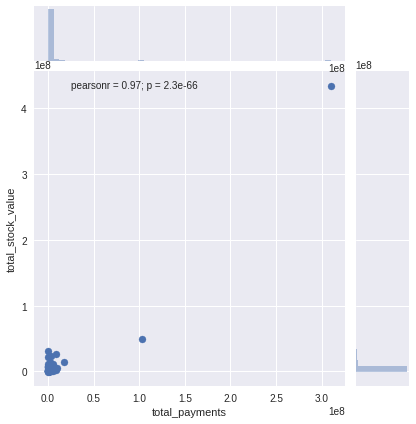

In [9]:
import seaborn as sns
%matplotlib inline
# if NaN strings are kept, need to filter these values
#df_plt = df[(df.total_payments != "NaN") & (df.total_stock_value != "NaN")]

# total payments vs total stock value
sns.jointplot(x="total_payments", y="total_stock_value", data=df, dropna=True)
sns.plt.show()

In [10]:
df[df.total_payments > 1e8].index

Index([u'LAY KENNETH L', u'TOTAL'], dtype='object')

In [11]:
df.total_payments.idxmax()

'TOTAL'

There are 2 significant outliers in the data.  The first and largest is `TOTAL` which is simply the sum of all observations, so this will be removed.  The other is Ken Lay, who was the CEO of Enron and a definite POI in the data.  Ken Lay will be kept, especially since there are few POIs to begin with.

In [12]:
df = df.drop('TOTAL')

In [13]:
# people with no financial data
df[df[financial_features].isnull().all(axis=1)].index

Index([u'LOCKHART EUGENE E'], dtype='object')

There is 1 person without any financial data that will also need to be removed.

In [14]:
df = df.drop('LOCKHART EUGENE E')

I've also decided to leave out some of the numerical email features.  Those that are from/to POI messages contain information about who and who is not a POI (ie data leakage).

In [15]:
leakage = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
features_list = [feat for feat in features_list if feat not in leakage]

To get an idea for what type of benchmark classifier to use, I want to see if the data looks remotely linearly separable (ie logistic regression or tree based/other).

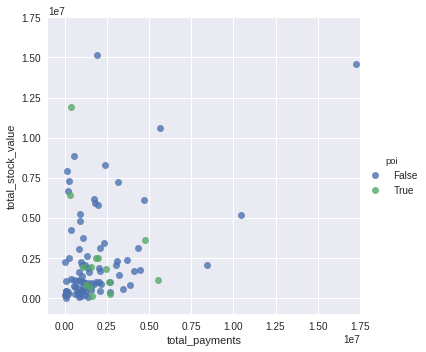

In [16]:
p = sns.lmplot('total_payments', 'total_stock_value', data=df, hue='poi', fit_reg=False)
p.set(xlim=(-1e6, 1.75e7), ylim=(-1e6, 1.75e7))
sns.plt.show()

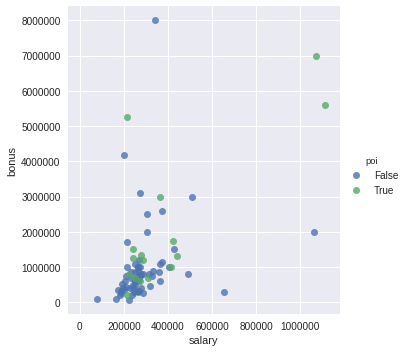

In [17]:
sns.lmplot('salary', 'bonus', data=df, hue='poi', fit_reg=False)
sns.plt.show()

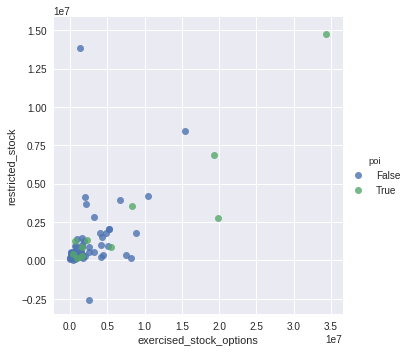

In [18]:
sns.lmplot('exercised_stock_options', 'restricted_stock', data=df, hue='poi', fit_reg=False)
sns.plt.show()

Not an exhaustive search (pairs plot function in seaborn can't handle NaN values) but I don't think a logistic regression is the best choice for a benchmark classifier.  I'll try naive bayes or decision tree...

In [19]:
# dataframe back to dictionary
df = df.replace(np.nan, 'NaN') # need to convert back to 'NaN' 
data_dict = df[features_list].to_dict(orient = 'index')

In [20]:
from benchmark import benchmark_score
benchmark_score(data_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.79700	Precision: 0.23914	Recall: 0.23950	F1: 0.23932	F2: 0.23943
	Total predictions: 15000	True positives:  479	False positives: 1524	False negatives: 1521	True negatives: 11476



In [21]:
# dump to pickle for checkpoint
with open("outlier_dataset.pkl", "w") as f_out:
    pickle.dump(data_dict, f_out)

## 2

**What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.**

During the data exploration and outlier removal process, I found some features with a large proportion of missing values.  There were also email features that incorporated information about POI status.  So these were all excluded from the features list:

- loan_advances
- director_fees
- restricted_stock_deferred
- from_this_person_to_poi
- from_poi_to_this_person

I created a few new features from the email corpus.  This was a pretty lengthy procedure.

I first had to perform an audit to be that sure people who had email addresses and numerical email data, in fact had email text data (see `audit_emails.py`).  Then I built an email corpus for each person of all to and from emails, while cleaning the text data in the process (see `build_email_corpus.py`).

In [42]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

with open("outlier_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [20]:
from build_email_corpus import build_email_dataset
build_email_dataset(data_dict)

0 paths not found
time to build corpus: 86.95 minutes


At this point each person had a new feature.  The feature is a list where every element in the list is the text for a single email.  There were too many emails to try a bag-of-words approach.  I actually tried both a count vectorizer as well as TfIdf (term frequency inverse document frequency) but the dimensionality of terms was too great.

I decided to reduce the dimensionality of the email corpus for each person using LDA (latent dirichlet allocation).  The emails for each person were then reduced to just a few topics and all topics were limited in the size of vocabulary (see `build_topic_corpus.py`).

In [24]:
with open("emails_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [25]:
from build_topic_corpus import build_topic_dataset
build_topic_dataset(data_dict)

time to build topics: 11.51 minutes


From here I used a random forest classifer with cross validation to extract words with predictive capability (see `create_word_features.py`).  The end result is that each person was given 10 new numerical features.  The feature name is the (hopefully) meaningful word and the value is the number of times that word occurred in that person's topic corpus.

In [34]:
with open("topic_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [35]:
from create_word_features import build_word_dataset
build_word_dataset(data_dict)

In [21]:
# final checkpoint
with open("word_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

With new features added, see if they have improved the benchmark score.

In [22]:
df = pd.DataFrame.from_dict(data_dict, orient = 'index')
all_features = df.columns.values.tolist()

In [23]:
from benchmark import benchmark_score
benchmark_score(data_dict, all_features)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.83287	Precision: 0.37229	Recall: 0.36950	F1: 0.37089	F2: 0.37006
	Total predictions: 15000	True positives:  739	False positives: 1246	False negatives: 1261	True negatives: 11754



including the new features defintely improved the score...

feature selection method, feature importances from decision tree classifier used on stratified folds of data...

In [24]:
from feature_selector import get_feature_scores
names, scores, ordered = get_feature_scores(data_dict)

/home/chris/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best features descending: ['exercised_stock_options', 'bonus', 'total_stock_value', u'holiday', 'expenses', 'other', 'restricted_stock', 'salary', 'deferred_income', 'total_payments', 'shared_receipt_with_poi', 'long_term_incentive', 'to_messages', 'from_messages', u'need', u'call', u'budget', u'regard', 'deferral_payments', u'date', u'volume', u'david', u'company', u'response']


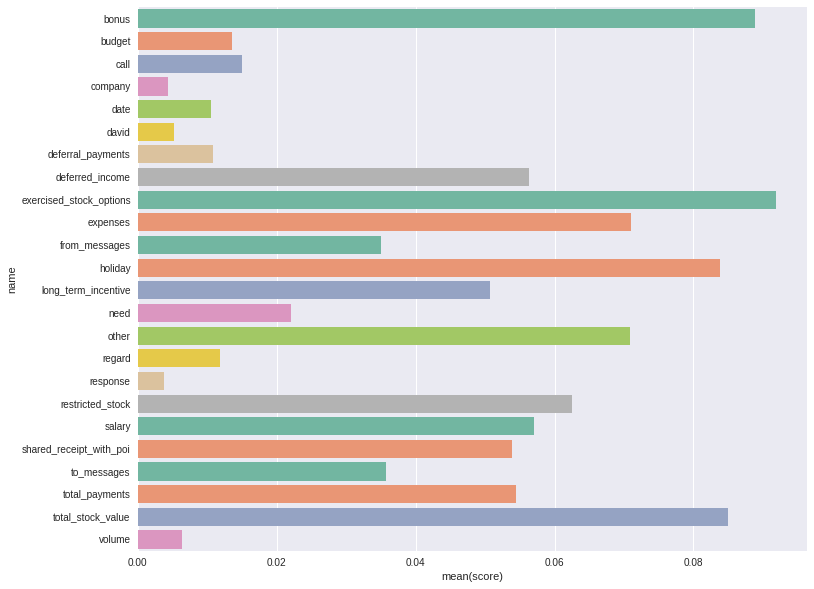

In [25]:
# plot names with scores
import matplotlib.pyplot as plt
df_plt = pd.DataFrame()
df_plt['name'] = names; df_plt['score'] = scores
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.barplot(y = "name", x = "score", data = df_plt,
            palette = sns.color_palette("Set2", 10))
sns.plt.show()

arbitrary cutoff after 0.06, keep
- bonus
- exercised stock options
- expenses
- holiday (made use of email data)
- other
- restricted stock
- total stock value

score after reducing features...

In [27]:
reduced_features = ['poi'] + ordered[0:7]

In [28]:
# after reducing features
benchmark_score(data_dict, reduced_features)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82307	Precision: 0.37948	Recall: 0.37550	F1: 0.37748	F2: 0.37629
	Total predictions: 14000	True positives:  751	False positives: 1228	False negatives: 1249	True negatives: 10772



score slightly improved, but pretty much the same.  can say that these features probably capture most importance in differentiating POIs...

# restart here

In [60]:
import sys
sys.path.append("../tools/") # path for 'feature_format.py'
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
# format for model testing
data = featureFormat(data_dict, reduced_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [63]:
### Task 4: Try a variety of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
from sklearn.ensemble import AdaBoostClassifier
#clf = AdaBoostClassifier()
from sklearn.neighbors import KNeighborsClassifier
#clf = KNeighborsClassifier()

### Scaling and PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

estimators = [('scaler', StandardScaler()), ('reducer', PCA()), \
    ('ada', AdaBoostClassifier())]  ## scaling and PCA vastly improve AdaBoost
#estimators = [('scaler', MinMaxScaler()), \
    #('knn',  KNeighborsClassifier())] ## KNN requires range scaling


### Classifier Selection
#clf = GaussianNB()  ## this is the benchmark 
clf = Pipeline(estimators)

In [64]:
### Parameter Optimization
#from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

## standard scaler, pca, adaboost
parameters = dict(ada__base_estimator = \
    [DecisionTreeClassifier(), DecisionTreeClassifier(max_depth = 5), \
    DecisionTreeClassifier(max_depth = 8)], \
    ada__learning_rate = [5.0, 10.0, 20.0])
## min-max scaler, knn
#parameters = dict(knn__n_neighbors = range(1, 6), \
    #knn__weights = ['uniform', 'distance'])

sss = StratifiedShuffleSplit(labels_train, random_state = 11)
## best cross-validation method for small data set and few POIs
clf = GridSearchCV(clf, param_grid = parameters, scoring = 'recall', \
    cv = sss, verbose = 1)  ## maximizing the f1 score, recall results in same

## grid fit for best estimator
clf.fit(features_train, labels_train)

## assign classifier to best estimator
clf = clf.best_estimator_
#print "\nBest parameters: \n", clf.get_params()

/home/chris/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.2s finished


In [18]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.model_selection import StratifiedShuffleSplit 
### Evaluation Metrics
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score, f1_score

## convert features and labels to arrays
#print type(labels), type(features)
features = np.asarray(features)
labels = np.asarray(labels)

## lists of metrics
accuracy = []
precision = []
recall = []
f_one = []

## or for classification report
total_labels = np.array([])
total_preds = np.array([])

folds = 200
sss = StratifiedShuffleSplit(labels, folds, test_size = 0.3, random_state = 11)

for train_idx, test_idx in sss:
    features_train, labels_train = features[train_idx], labels[train_idx]
    features_test, labels_test = features[test_idx], labels[test_idx]
    
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    #pred = clf.fit_predict(features) ## k-means
    
    #acc = clf.score(features_test, labels_test)
    acc = accuracy_score(labels_test, pred)
    pre = precision_score(labels_test, pred)
    rec = recall_score(labels_test, pred)
    f1 = f1_score(labels_test, pred)
    
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    f_one.append(f1)
    
    total_labels = np.concatenate((total_labels, labels_test))
    total_preds = np.concatenate((total_preds, pred))

## not quite the same as tester.py
print "\nAccuracy: ", sum(accuracy)/folds, "\nPrecision: ", \
    sum(precision)/folds, "\nRecall: ", sum(recall)/folds, \
    "\nF1-Score: ", sum(f_one)/folds

TypeError: __init__() got multiple values for keyword argument 'test_size'

In [20]:
## using sklearn
from sklearn.metrics import classification_report
## precision, recall, f1-score, and support (number of occurrences in test set)
print "\n", classification_report(total_labels, total_preds, \
    target_names=['non-POI', 'POI']) ## these scores appear to be less accurate


             precision    recall  f1-score   support

    non-POI       0.92      0.91      0.92      6800
        POI       0.45      0.48      0.46      1000

avg / total       0.86      0.86      0.86      7800



In [65]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, data_dict, features_list)


Using additional script for better evaluation metrics...


In [23]:
import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/") # DIFFERENT GITHUB PATH HERE
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    pickle.dump(clf, open(CLF_PICKLE_FILENAME, "w") )
    pickle.dump(dataset, open(DATASET_PICKLE_FILENAME, "w") )
    pickle.dump(feature_list, open(FEATURE_LIST_FILENAME, "w") )

def load_classifier_and_data():
    clf = pickle.load(open(CLF_PICKLE_FILENAME, "r") )
    dataset = pickle.load(open(DATASET_PICKLE_FILENAME, "r") )
    feature_list = pickle.load(open(FEATURE_LIST_FILENAME, "r"))
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

In [24]:
main()

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reducer', PCA(copy=True, n_components=None, whiten=False)), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            ...dom_state=None, splitter='best'),
          learning_rate=5.0, n_estimators=50, random_state=None))])
	Accuracy: 0.84869	Precision: 0.50833	Recall: 0.50350	F1: 0.50590	F2: 0.50446
	Total predictions: 13000	True positives: 1007	False positives:  974	False negatives:  993	True negatives: 10026

